In [16]:
import pandas as pd
import numpy as np

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
import os, cv2, matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical

In [3]:
dataset_path = '/content/drive/MyDrive/Machine Learning Project/Dataset'

In [20]:
from pathlib import Path

def load_images_labels(dataset_path):
    images = []
    labels = []
    categories = [d.name for d in Path(dataset_path).iterdir() if d.is_dir()]

    for label, category in enumerate(categories):
        for image_path in Path(dataset_path).joinpath(category).glob('*'):
            image = cv2.imread(str(image_path))
            if image is not None:
                image = cv2.resize(image, (64, 64))
                images.append(image)
                labels.append(label)

    return np.array(images), np.array(labels)

images, labels = load_images_labels(dataset_path)


In [32]:
images = images.astype('float32') / 255.0

In [23]:
import numpy as np
num_test_samples = int(0.2 * len(images))
test_indices = np.random.choice(len(images), size=num_test_samples, replace=False)
train_mask = np.ones(len(images), dtype=bool)
train_mask[test_indices] = False
test_mask = ~train_mask
X_train = images[train_mask]
X_test = images[test_mask]
y_train = labels[train_mask]
y_test = labels[test_mask]

In [7]:
y_train_cnn = to_categorical(y_train)
y_test_cnn = to_categorical(y_test)


In [24]:
import cv2

def extract_hog_features_cv(images):
    hog_features = []
    hog_descriptor = cv2.HOGDescriptor((64, 64), (16, 16), (8, 8), (8, 8), 9)
    for image in images:
        gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
        features = hog_descriptor.compute(gray)
        hog_features.append(features)
    return np.array(hog_features)

hog_train_features = extract_hog_features_cv(X_train)
hog_test_features = extract_hog_features_cv(X_test)

In [25]:
svm = SVC(kernel='linear', probability=True)
svm.fit(hog_train_features, y_train)

SVC(kernel='linear', probability=True)

In [26]:
from sklearn.metrics import classification_report, accuracy_score
svm_predictions = svm.predict(hog_test_features)
label_names = ["Bus", "Car", "Truck", "Motorcycle"]
svm_predictions_labels = [label_names[i] for i in svm_predictions]
y_test_labels = [label_names[i] for i in y_test]
print("SVM Classification Report:\n", classification_report(y_test_labels, svm_predictions_labels))
accuracy = accuracy_score(y_test, svm_predictions)
print(f"SVM Accuracy: {accuracy:.2f}")

SVM Classification Report:
               precision    recall  f1-score   support

         Bus       0.36      0.53      0.43        17
         Car       0.62      0.62      0.62        21
  Motorcycle       0.80      0.63      0.71        19
       Truck       0.74      0.61      0.67        23

    accuracy                           0.60        80
   macro avg       0.63      0.60      0.61        80
weighted avg       0.64      0.60      0.61        80

SVM Accuracy: 0.60


In [27]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(labels)), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
history = cnn_model.fit(X_train, y_train_cnn, epochs=10, batch_size=32, validation_data=(X_test, y_test_cnn))

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 0.2685 - loss: 1.5527 - val_accuracy: 0.2250 - val_loss: 1.4018
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 364ms/step - accuracy: 0.2867 - loss: 1.3746 - val_accuracy: 0.2250 - val_loss: 1.3845
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.3698 - loss: 1.3680 - val_accuracy: 0.2875 - val_loss: 1.3817
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.4193 - loss: 1.3410 - val_accuracy: 0.2750 - val_loss: 1.3901
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.4141 - loss: 1.2831 - val_accuracy: 0.2250 - val_loss: 1.4294
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.3473 - loss: 1.3182 - val_accuracy: 0.2750 - val_loss: 1.4035
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - accuracy: 0.5040 - loss: 1.1587 - val_accuracy: 0.3125 - val_loss: 1.4455
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.6329 - loss: 1.0463 - val_accuracy: 0.

In [13]:
cnn_eval = cnn_model.evaluate(X_test, y_test_cnn)
print("CNN Test Accuracy:", cnn_eval[1])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5734 - loss: 1.0319
CNN Test Accuracy: 0.6000000238418579


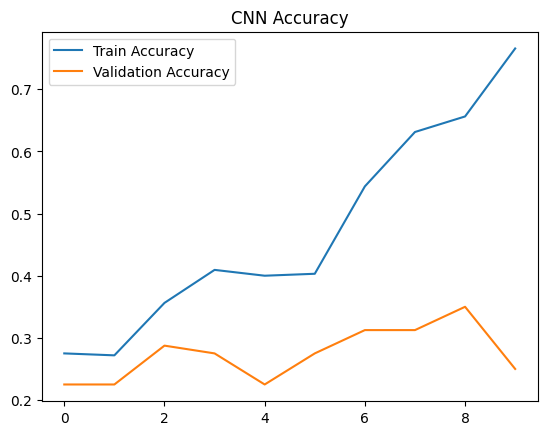

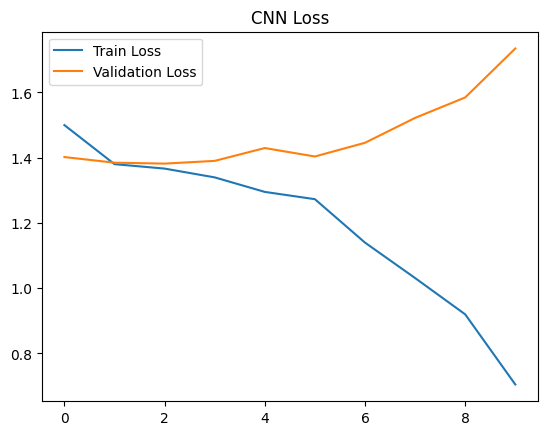

In [33]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss')
plt.legend()
plt.show()

In [31]:
cnn_model.save("vehicle_type_cnn_model.h5")
